## Fashion Forge

1. Setting up Environment

In [3]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices("GPU"))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured with memory growth")
else:
    print("No GPU detected")

GPU configured with memory growth


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

2. Import Dataset and Check it

## This loads the fashion MNIST dataset

(X_train, y_train)(X_test, y_test)

_ discards the test dataset because we only need the training images.

Values between 0 and 255 -> Different shades of gray.

0 -> Black
127 -> Medium Gray
255 -> White

In [7]:
(x_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
print("Data shape", x_train.shape)

Data shape (60000, 28, 28)


[]

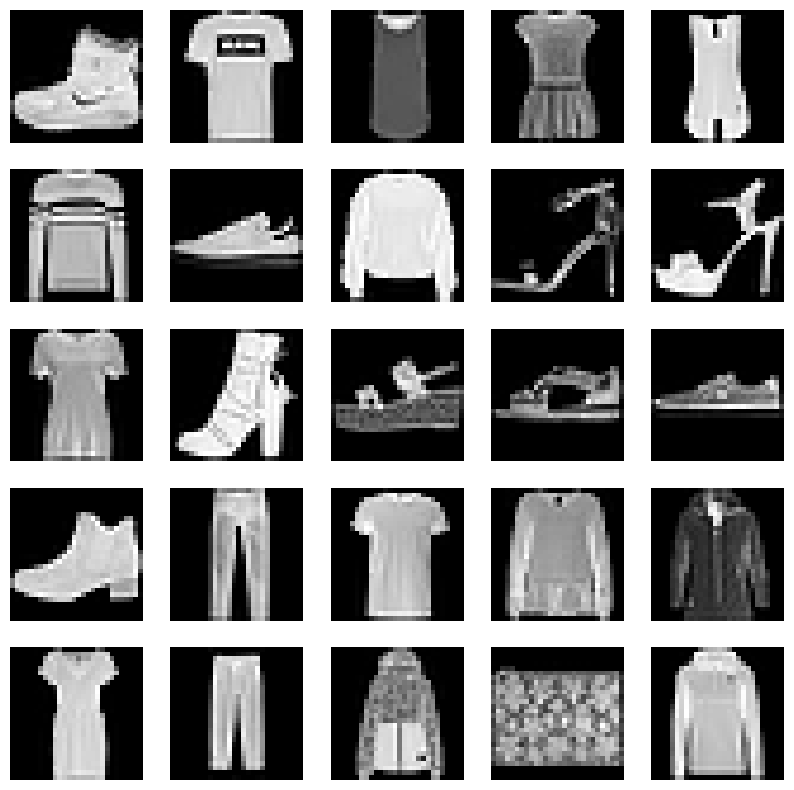

In [9]:
plt.figure(figsize=(10, 10))
for i in range (25):
  plt.subplot(5, 5, i+1)
  plt.imshow(x_train[i], cmap="gray")
  plt.axis("off")
plt.plot()

3. Create a Data Pipeline

In [10]:
x_train.shape[0]

60000

### Normalizing the data

x_train.shape[0] -> Represents the number of images (60,000 in Fashion MNIST). 28, 28 -> The images are 28x28 pixels (grayscale). -> The extra dimension is added to indicate one color channel (grayscale).

astype("float32") -> Convert them to floating point numbers, which are needed for our neural network to work efficiently.

x_train = (x_train - 127.5) / 127.5

The pixel value are originally stored as integer (0-255), GANs work better in the range [-1, 1] instead of [0, 255]

In [11]:
# Normalise and reshape the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32")
x_train = (x_train - 127.5) / 127.5

In [12]:
x_train.shape

(60000, 28, 28, 1)

BUFFER_SIZE = 60000: Ensures complete shuffling of the dataset every epoch for diverse training.

BATCH_SIZE = 256: Determines the number of images processed at once, balancing memory usage and training speed.

In [13]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [14]:
x_train

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

Before batching (60000, 28, 28, 1) -> 60,000 individual images.

After batching (256, 28, 28, 1) Each batch contain 256 images.

Total number of batch per epoch would be -> 60000/256 = 235

-> Converting x_train into a tensorflow dataset

-> Shuffles the dataset (to prevent order bias)

-> Batches the dataset into group of 256 images for efficient training.

In [15]:
# Create the tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

mean = 0.0 is commonly used in GANs, sometimes a small non-zero mean can improve stability.

Default -> mean = 0.0 (safe, but can be improved). Better choice -> mean=0.01 or mean=0.02 for faster and more stable training.

Why stddev = 0.02?

Based on research (from DCGAN paper), stddev=0.02 helps GANs generate sharper images. Ensures the network starts with balanced gradients.

In [16]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.8, stddev=0.02)

4. Create a Generator and a Discriminator

In [17]:
def build_generator():
  model = keras.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Reshape the output of the Dense layer to a 4D tensor
    layers.Reshape((7, 7, 256)),

    layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh")
])
  return model

generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# build the discriminator
def build_discriminator():
  model = keras.Sequential([
      # First Conv2d layer: Detect low level features in the images (edges, textures, ...)
      layers.Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=[28,28,1]),

      # LeakyRelu activation function to avoid dead neurins and allow negative gradients
      layers.LeakyReLU(0.2),
      # dropout to prevent overfitting and to improve generalization
      layers.Dropout(0.3),

      # First Conv2d layer: learn more complex features from the images
      layers.Conv2D(128, (5,5), strides=(2,2), padding="same", input_shape=[28,28,1]),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.3),

      # Flatten the 2D feature maps into a 1D vector for the Dense layer
      layers.Flatten(),

      # Output layer
      layers.Dense(1, activation="sigmoid")
])

  return model

discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
cross_entropy = keras.losses.BinaryCrossentropy()

### Create the generator and the discrimintor losses

In [20]:
# Create the discriminator loss
def discriminator_loss(real_output, fake_output):
  # calculates the loss when the discriminator classify fake images
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)

  # calculates the loss when the discriminator classify fake images
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  # Return the sum of both losses
  return real_loss + fake_loss

In [21]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

### Building a sub class model

In [23]:
# Building our sub class model
class GAN(keras.Model):
  def __init__(self, generator, discriminator):
    # Initialize the GAN model with the generator and discriminator
    super(GAN, self).__init__()
    self.generator = generator #set generator model
    self.discriminator = discriminator #set discriminator model

  def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer # set the generator optmizer
    self.d_optimizer = d_optimizer # set the discriminator optimizer
    self.g_loss = g_loss # set the generator loss
    self.d_loss = d_loss # set the discriminator loss

  def train_step(self, real_images):
  # Training logic
    batch_size = tf.shape(real_images)[0]

    # Train discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as d_tape:
        generated_images = self.generator(noise)
        real_output = self.discriminator(real_images)
        fake_output = self.discriminator(generated_images)
        d_loss = self.d_loss(real_output, fake_output)

    # Computing the gradients for the discriminator based in its loss
    d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}


In [24]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.seed = tf.random.normal([num_images, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5 #rescaleto range [0, 255]

      plt.figure(figsize=(10,10))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
      plt.show()

5. Train the Dataset

In [25]:
EPOCH = 100

In [26]:
gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - d_loss: 1.2370 - g_loss: 0.7916

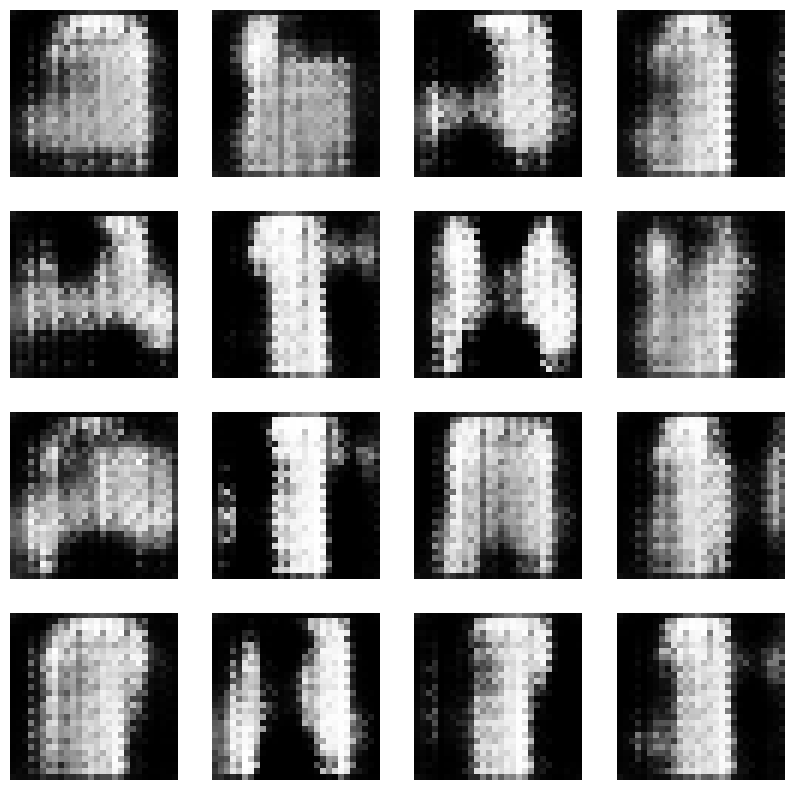

235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - d_loss: 1.2377 - g_loss: 0.7911
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3196 - g_loss: 0.7896
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3044 - g_loss: 0.8021
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.2640 - g_loss: 0.8575
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.2547 - g_loss: 0.8914
Epoch 6/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3167 - g_loss: 0.8067

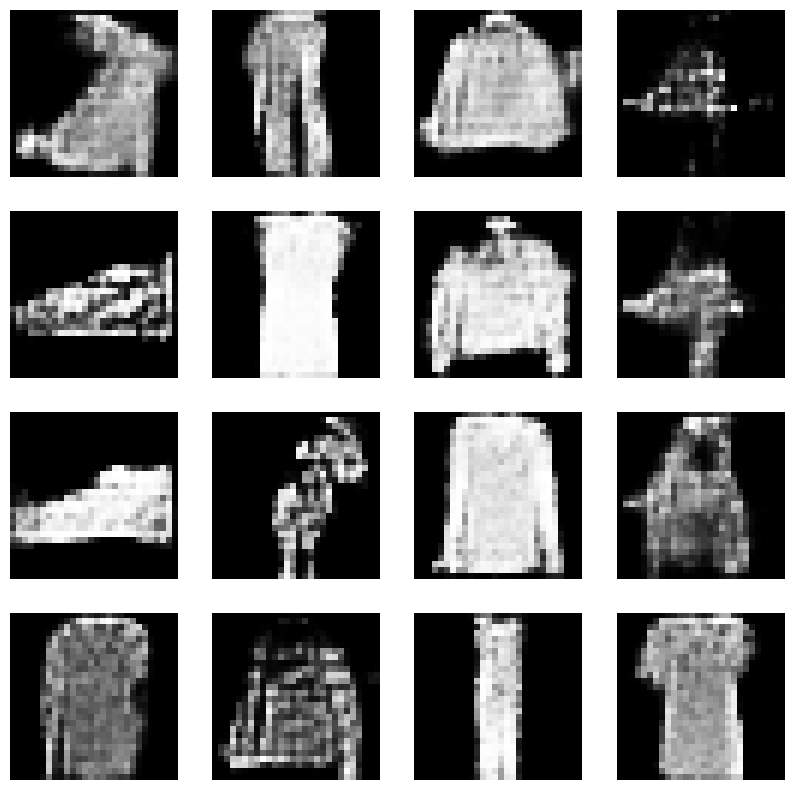

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3172 - g_loss: 0.8065
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3397 - g_loss: 0.7665
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3365 - g_loss: 0.7558
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3331 - g_loss: 0.7596
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3343 - g_loss: 0.7607
Epoch 11/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3370 - g_loss: 0.7728

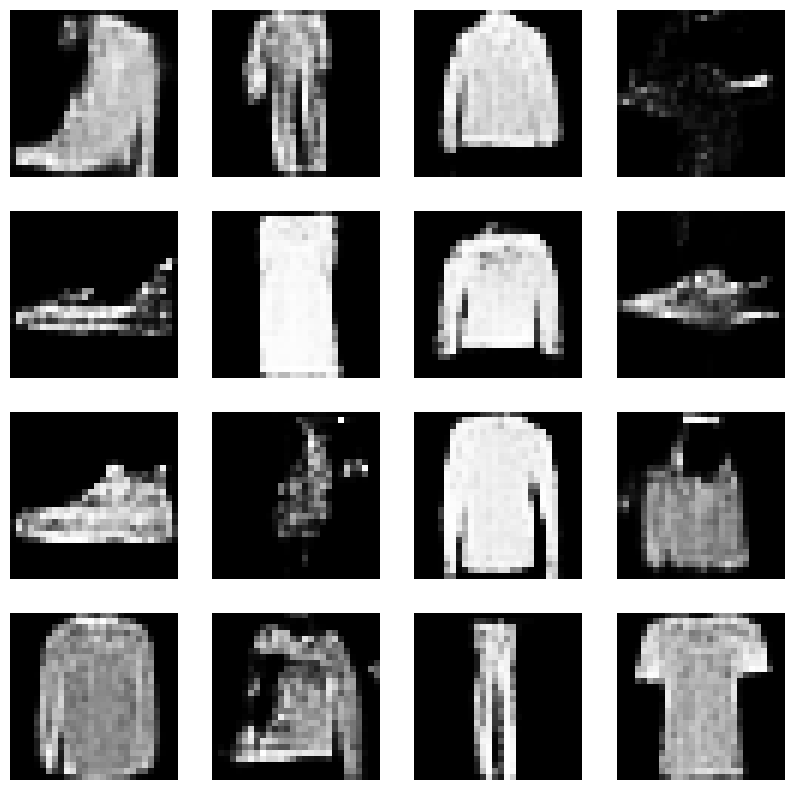

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3372 - g_loss: 0.7730
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3336 - g_loss: 0.7672
Epoch 13/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3340 - g_loss: 0.7667
Epoch 14/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3328 - g_loss: 0.7708
Epoch 15/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3382 - g_loss: 0.7744
Epoch 16/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3347 - g_loss: 0.7686

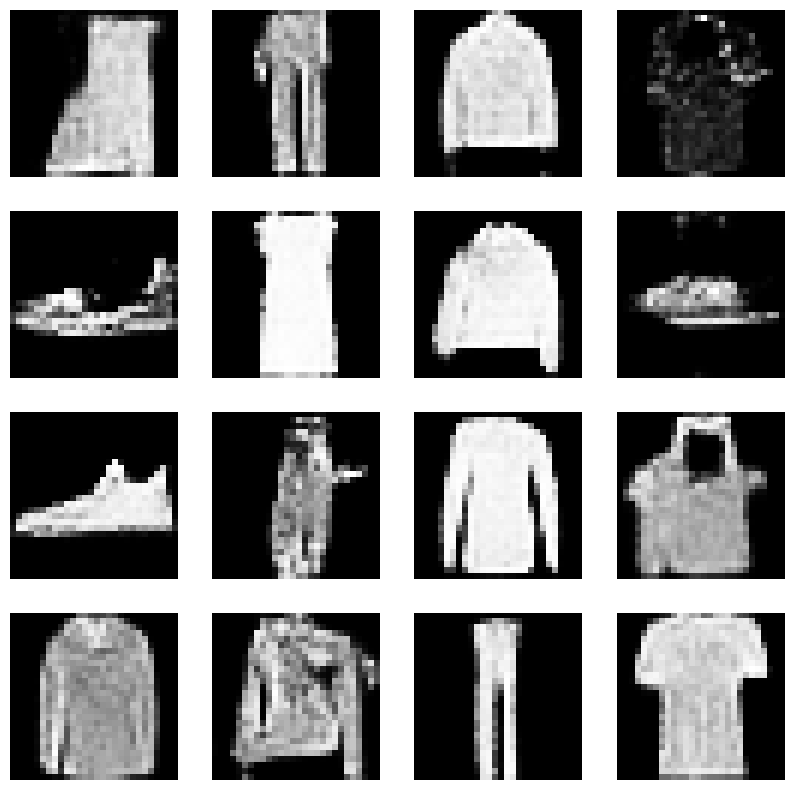

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3348 - g_loss: 0.7685
Epoch 17/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3374 - g_loss: 0.7665
Epoch 18/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3386 - g_loss: 0.7645
Epoch 19/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3412 - g_loss: 0.7684
Epoch 20/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3396 - g_loss: 0.7629
Epoch 21/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3411 - g_loss: 0.7699

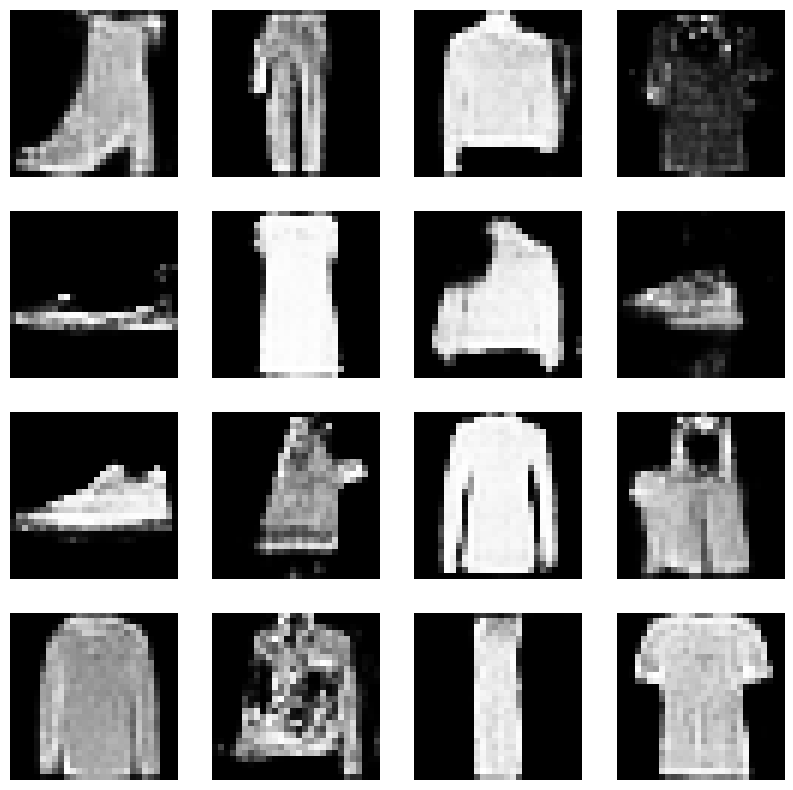

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - d_loss: 1.3410 - g_loss: 0.7702
Epoch 22/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3387 - g_loss: 0.7610
Epoch 23/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3407 - g_loss: 0.7702
Epoch 24/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3394 - g_loss: 0.7651
Epoch 25/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3407 - g_loss: 0.7686
Epoch 26/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3403 - g_loss: 0.7645

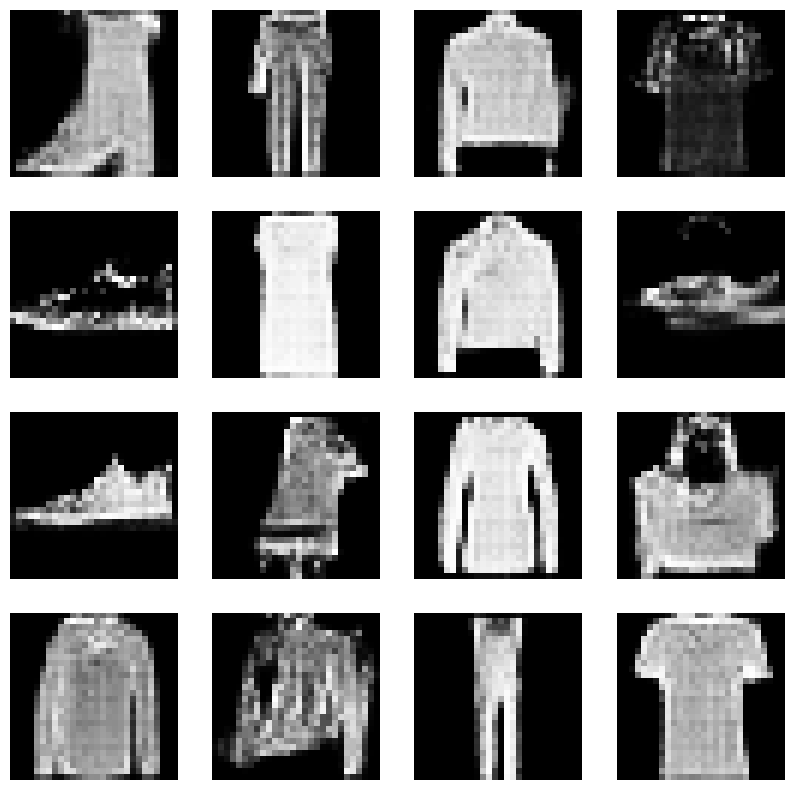

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3403 - g_loss: 0.7659
Epoch 27/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3410 - g_loss: 0.7660
Epoch 28/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3402 - g_loss: 0.7629
Epoch 29/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3371 - g_loss: 0.7641
Epoch 30/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3402 - g_loss: 0.7654
Epoch 31/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3399 - g_loss: 0.7759

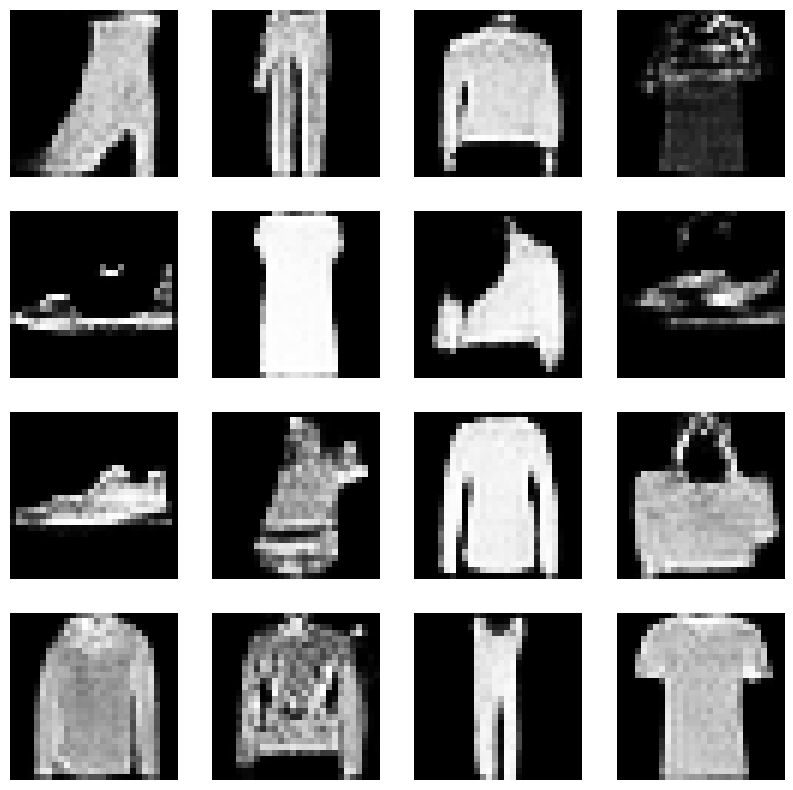

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3399 - g_loss: 0.7744
Epoch 32/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3392 - g_loss: 0.7626
Epoch 33/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3409 - g_loss: 0.7629
Epoch 34/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3431 - g_loss: 0.7681
Epoch 35/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3399 - g_loss: 0.7630
Epoch 36/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3426 - g_loss: 0.7650

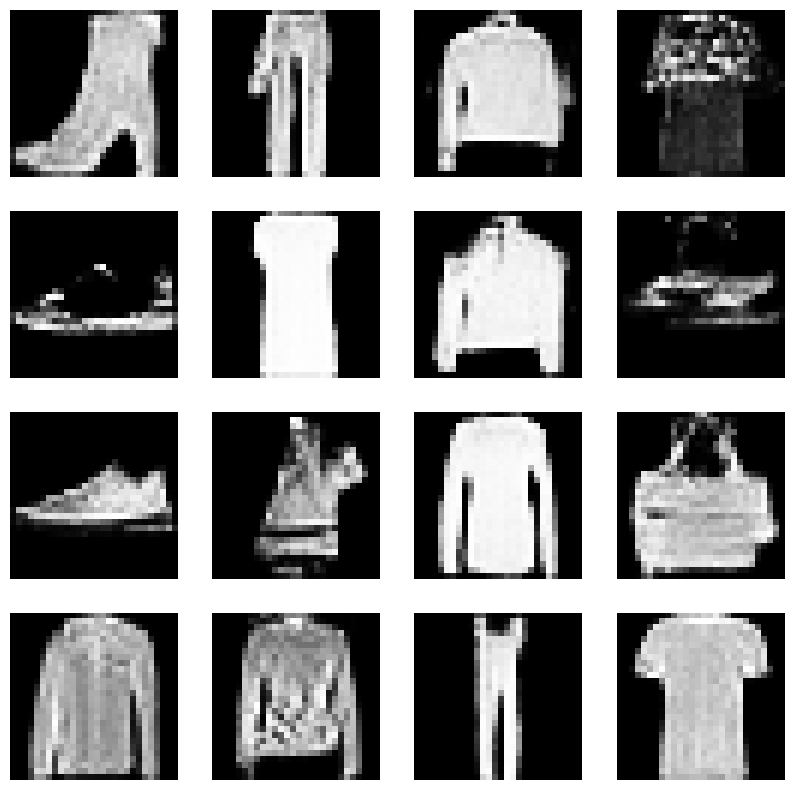

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3424 - g_loss: 0.7657
Epoch 37/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - d_loss: 1.3417 - g_loss: 0.7588
Epoch 38/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3416 - g_loss: 0.7661
Epoch 39/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3384 - g_loss: 0.7656
Epoch 40/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3409 - g_loss: 0.7649
Epoch 41/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3393 - g_loss: 0.7652

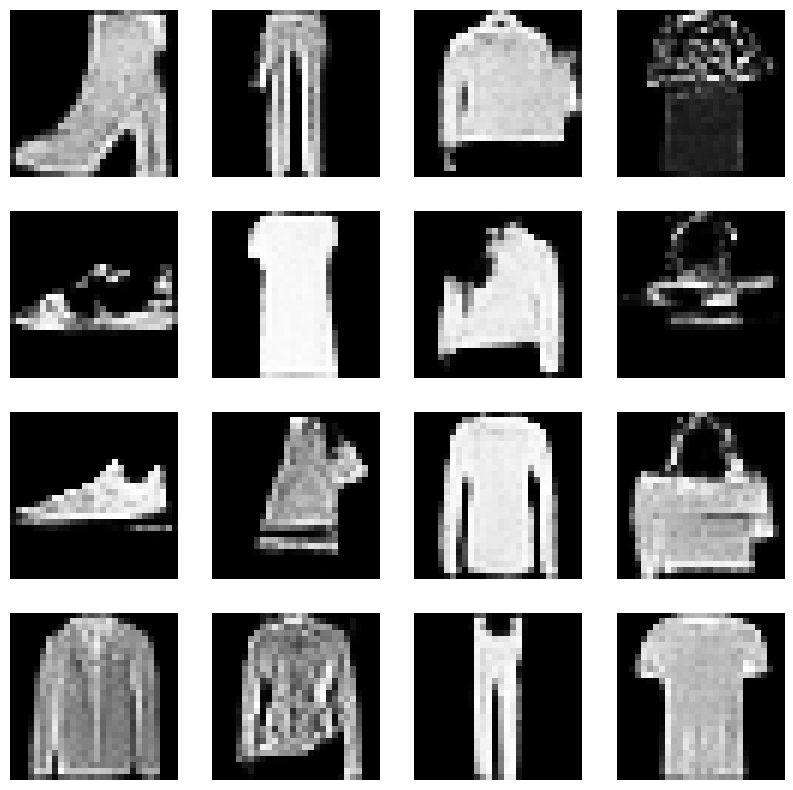

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3392 - g_loss: 0.7652
Epoch 42/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3376 - g_loss: 0.7597
Epoch 43/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3367 - g_loss: 0.7624
Epoch 44/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3398 - g_loss: 0.7711
Epoch 45/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3388 - g_loss: 0.7645
Epoch 46/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3383 - g_loss: 0.7654

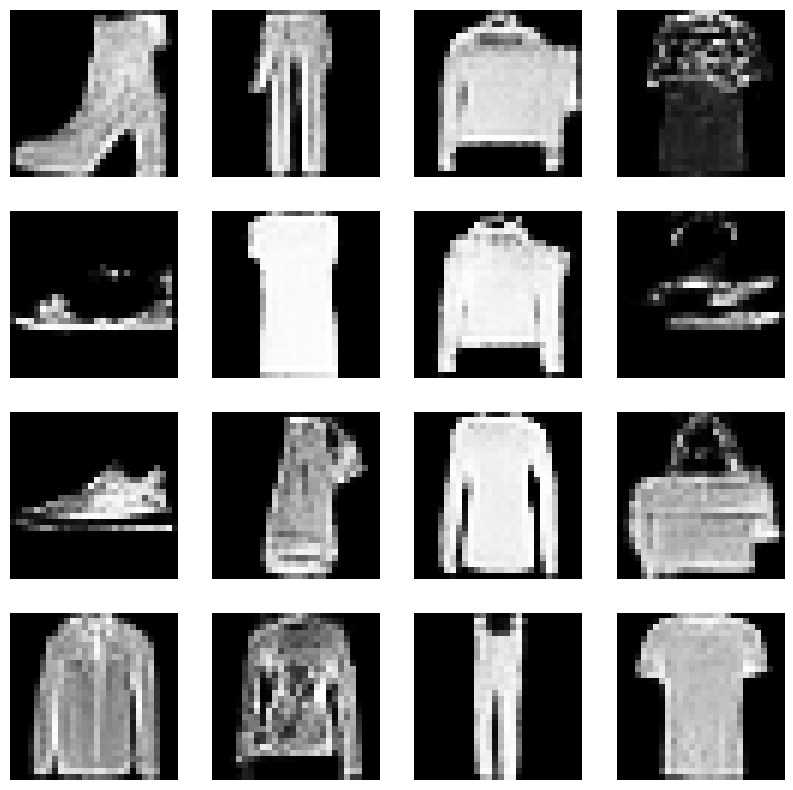

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3383 - g_loss: 0.7649
Epoch 47/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3350 - g_loss: 0.7626
Epoch 48/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3367 - g_loss: 0.7670
Epoch 49/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3378 - g_loss: 0.7684
Epoch 50/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3371 - g_loss: 0.7653
Epoch 51/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3368 - g_loss: 0.7692

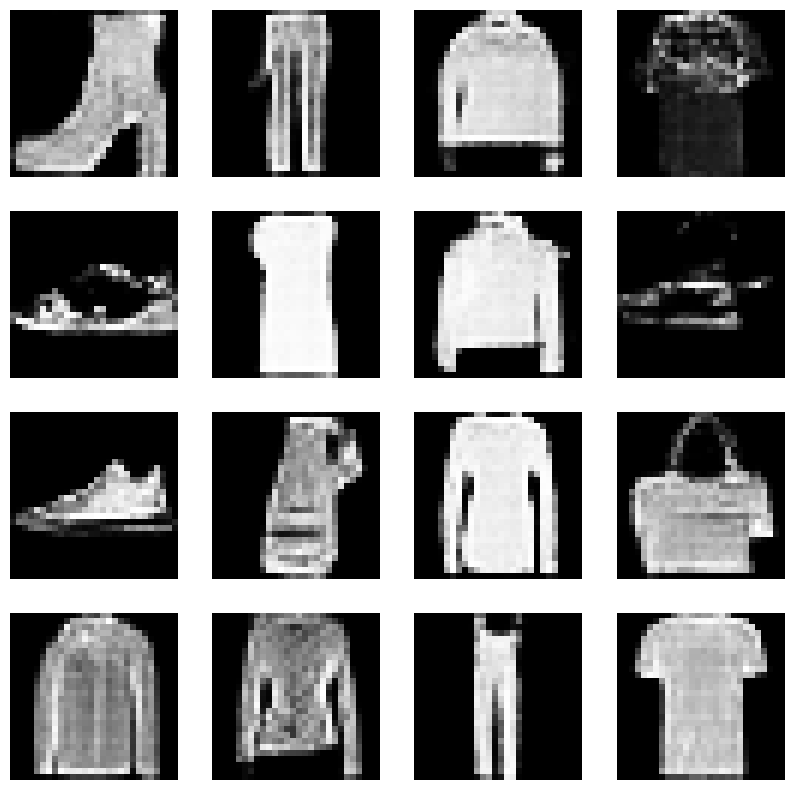

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3367 - g_loss: 0.7693
Epoch 52/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3395 - g_loss: 0.7669
Epoch 53/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3353 - g_loss: 0.7652
Epoch 54/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3333 - g_loss: 0.7712
Epoch 55/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3338 - g_loss: 0.7682
Epoch 56/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3373 - g_loss: 0.7701

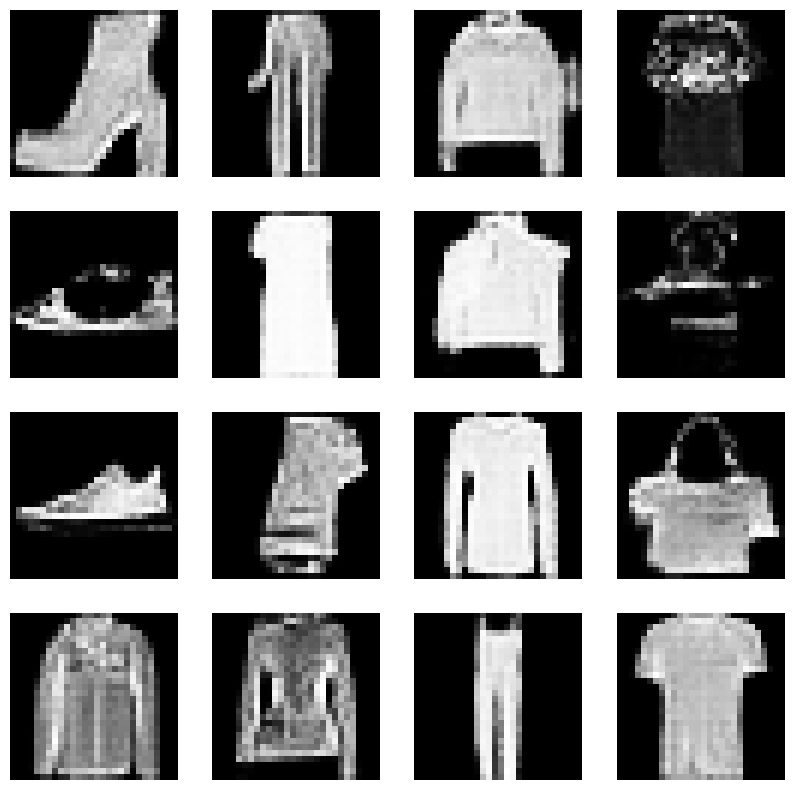

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3372 - g_loss: 0.7702
Epoch 57/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3348 - g_loss: 0.7667
Epoch 58/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3332 - g_loss: 0.7681
Epoch 59/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - d_loss: 1.3327 - g_loss: 0.7711
Epoch 60/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - d_loss: 1.3331 - g_loss: 0.7692
Epoch 61/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3318 - g_loss: 0.7711

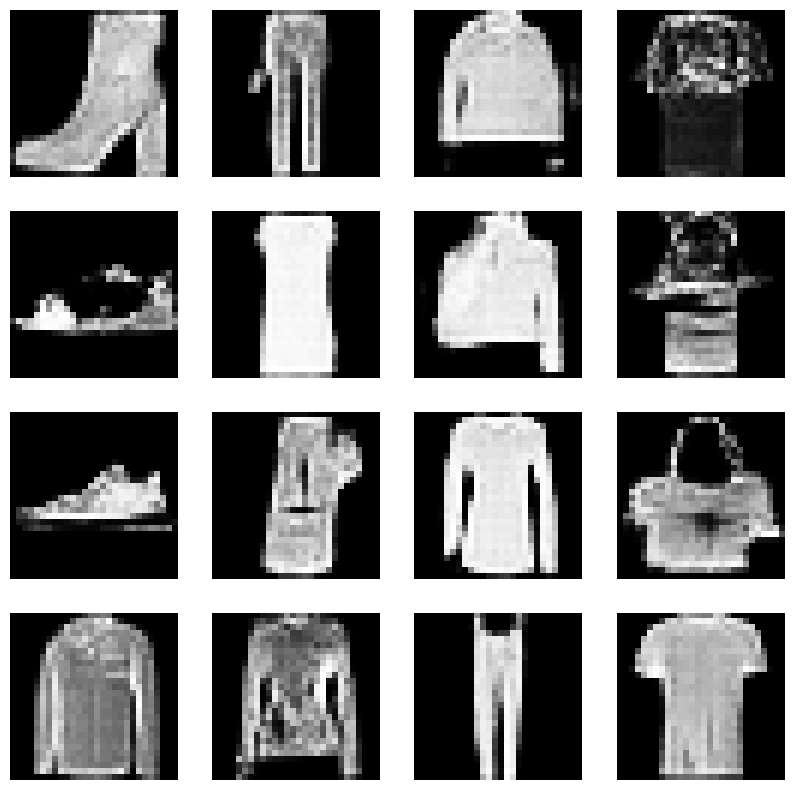

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3315 - g_loss: 0.7705
Epoch 62/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3292 - g_loss: 0.7693
Epoch 63/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3314 - g_loss: 0.7724
Epoch 64/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3305 - g_loss: 0.7734
Epoch 65/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3309 - g_loss: 0.7752
Epoch 66/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3311 - g_loss: 0.7738

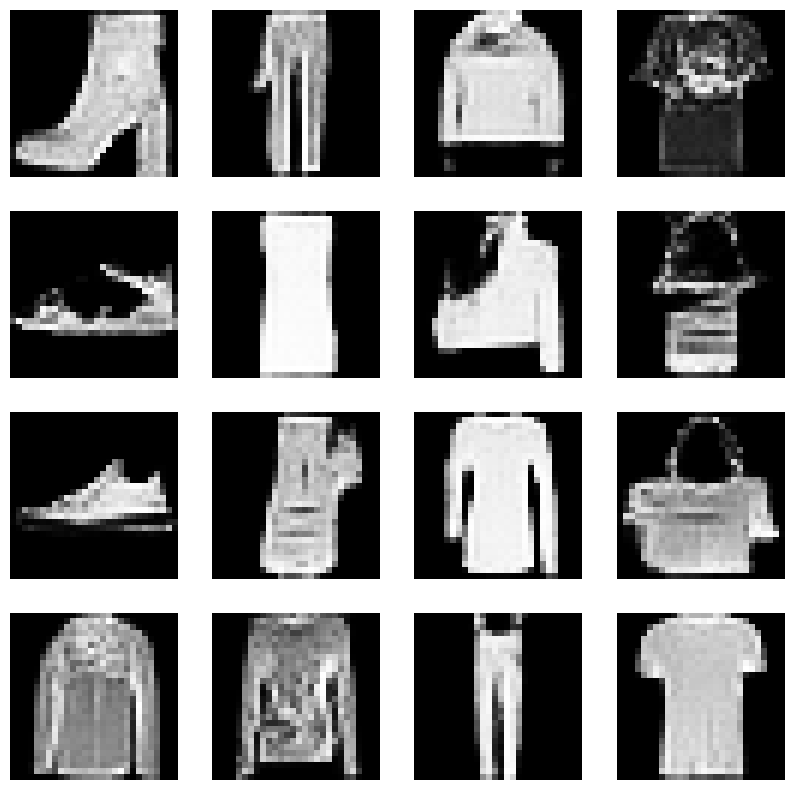

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3312 - g_loss: 0.7735
Epoch 67/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3302 - g_loss: 0.7773
Epoch 68/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3315 - g_loss: 0.7741
Epoch 69/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3268 - g_loss: 0.7762
Epoch 70/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3293 - g_loss: 0.7750
Epoch 71/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3269 - g_loss: 0.7776

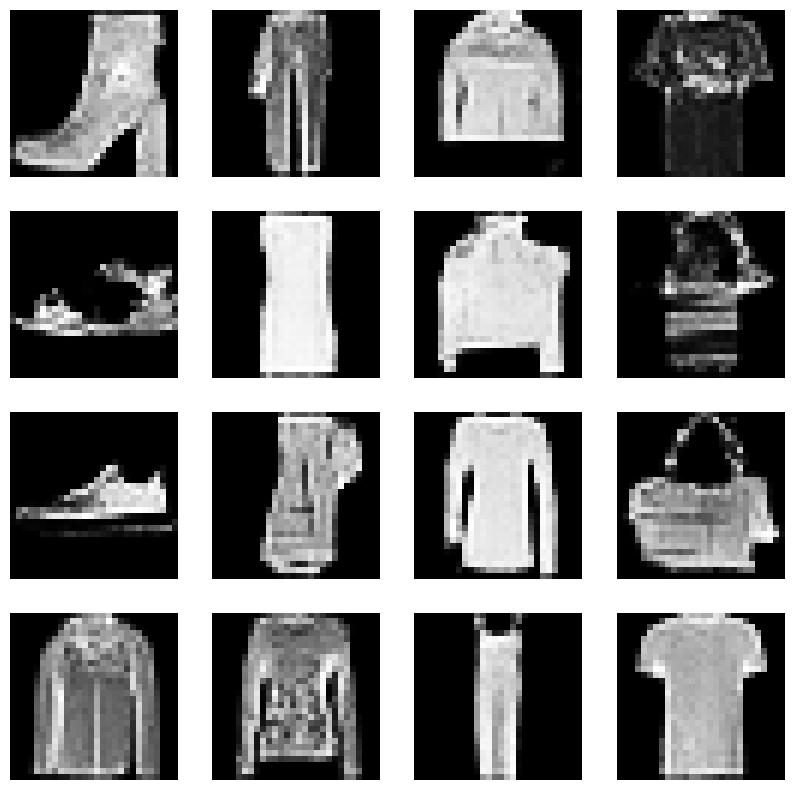

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3271 - g_loss: 0.7768
Epoch 72/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3259 - g_loss: 0.7789
Epoch 73/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3282 - g_loss: 0.7783
Epoch 74/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3275 - g_loss: 0.7749
Epoch 75/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3270 - g_loss: 0.7801
Epoch 76/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 1.3257 - g_loss: 0.7798

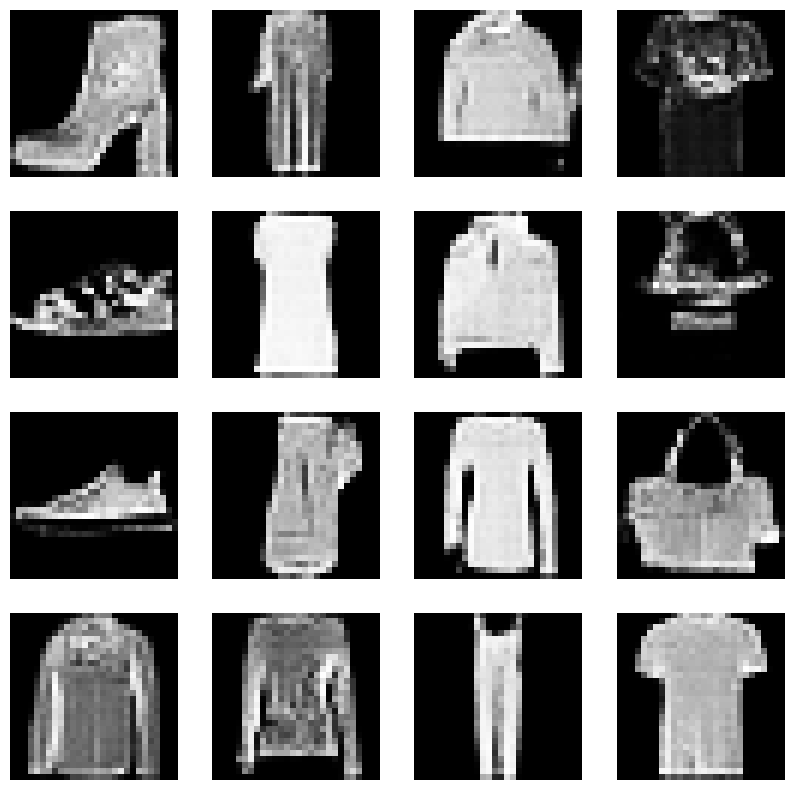

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3257 - g_loss: 0.7796
Epoch 77/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3261 - g_loss: 0.7779
Epoch 78/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3233 - g_loss: 0.7757
Epoch 79/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3231 - g_loss: 0.7770
Epoch 80/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3239 - g_loss: 0.7796
Epoch 81/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 1.3215 - g_loss: 0.7790

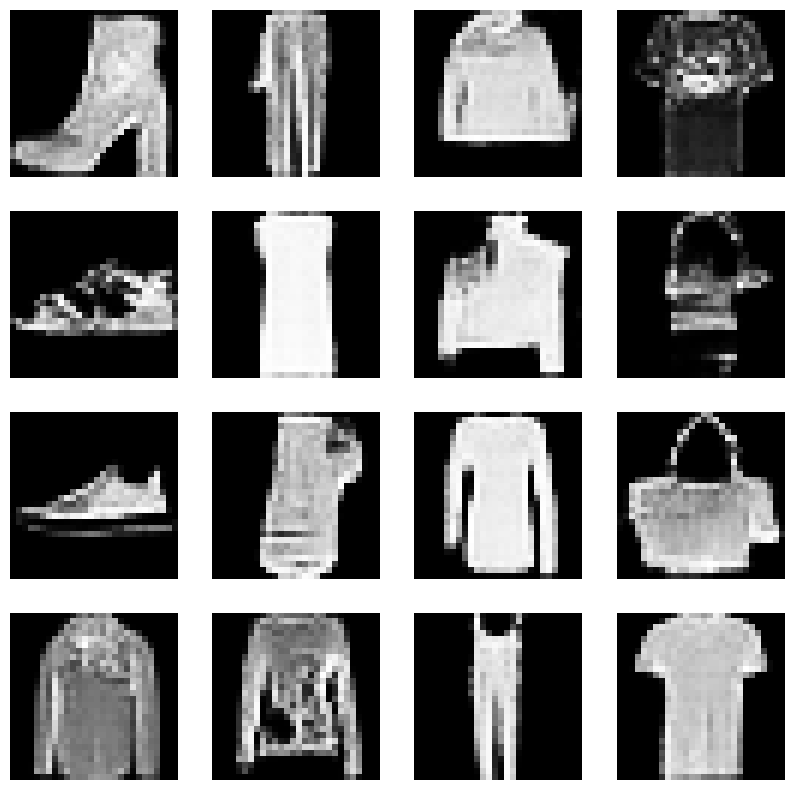

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - d_loss: 1.3212 - g_loss: 0.7807
Epoch 82/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3229 - g_loss: 0.7813
Epoch 83/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3213 - g_loss: 0.7823
Epoch 84/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3221 - g_loss: 0.7814
Epoch 85/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3219 - g_loss: 0.7821
Epoch 86/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3213 - g_loss: 0.7835

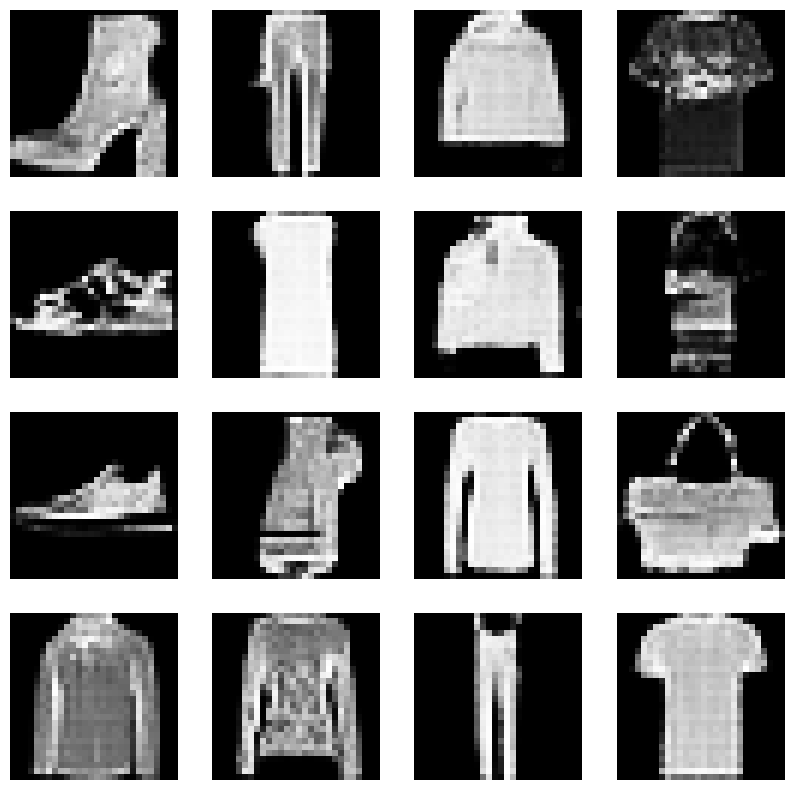

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3217 - g_loss: 0.7829
Epoch 87/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3203 - g_loss: 0.7799
Epoch 88/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3206 - g_loss: 0.7834
Epoch 89/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3226 - g_loss: 0.7847
Epoch 90/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3205 - g_loss: 0.7853
Epoch 91/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 1.3196 - g_loss: 0.7871

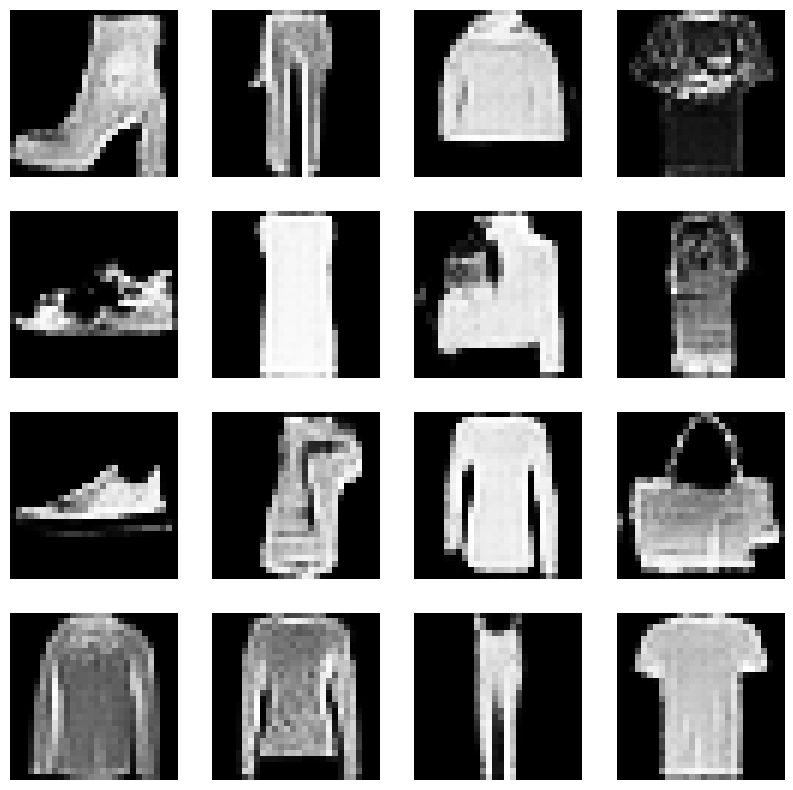

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3191 - g_loss: 0.7880
Epoch 92/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3212 - g_loss: 0.7875
Epoch 93/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3159 - g_loss: 0.7826
Epoch 94/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3200 - g_loss: 0.7876
Epoch 95/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - d_loss: 1.3197 - g_loss: 0.7871
Epoch 96/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3182 - g_loss: 0.7842

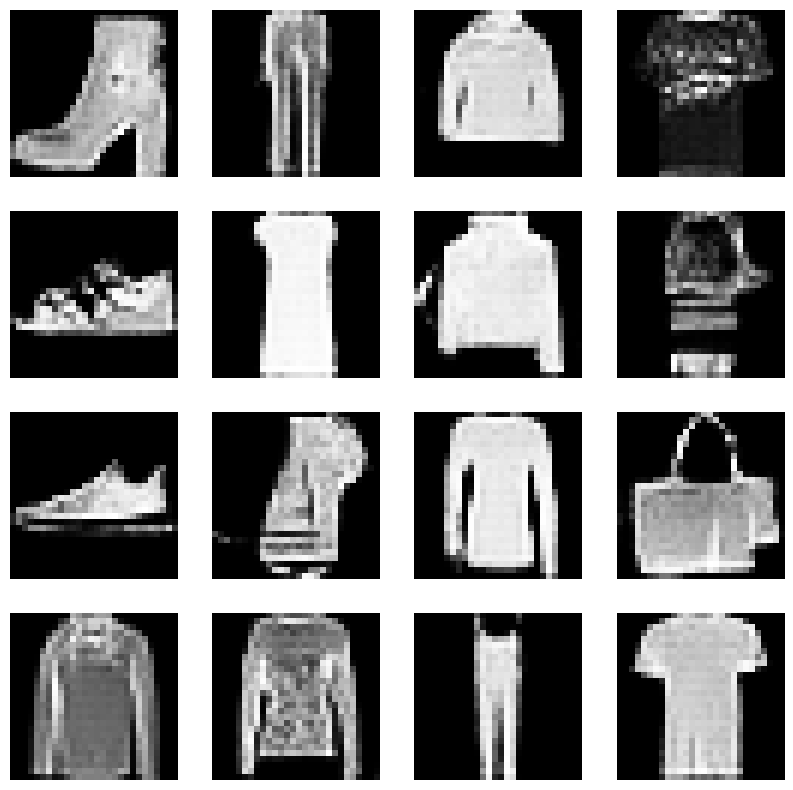

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3182 - g_loss: 0.7836
Epoch 97/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3170 - g_loss: 0.7870
Epoch 98/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3183 - g_loss: 0.7896
Epoch 99/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3155 - g_loss: 0.7858
Epoch 100/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3142 - g_loss: 0.7923


In [27]:
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()])

6. Evaluate the model and save it.

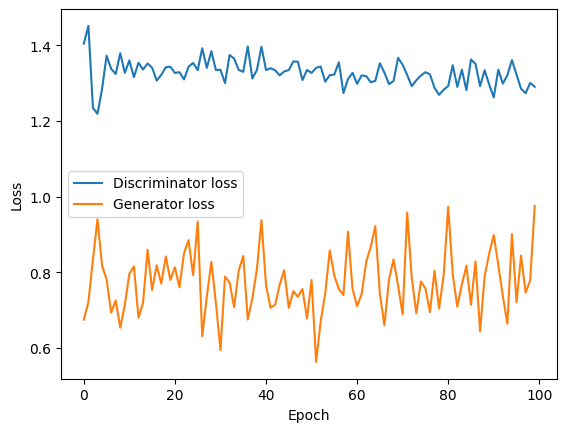

In [28]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5 # denormalize

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

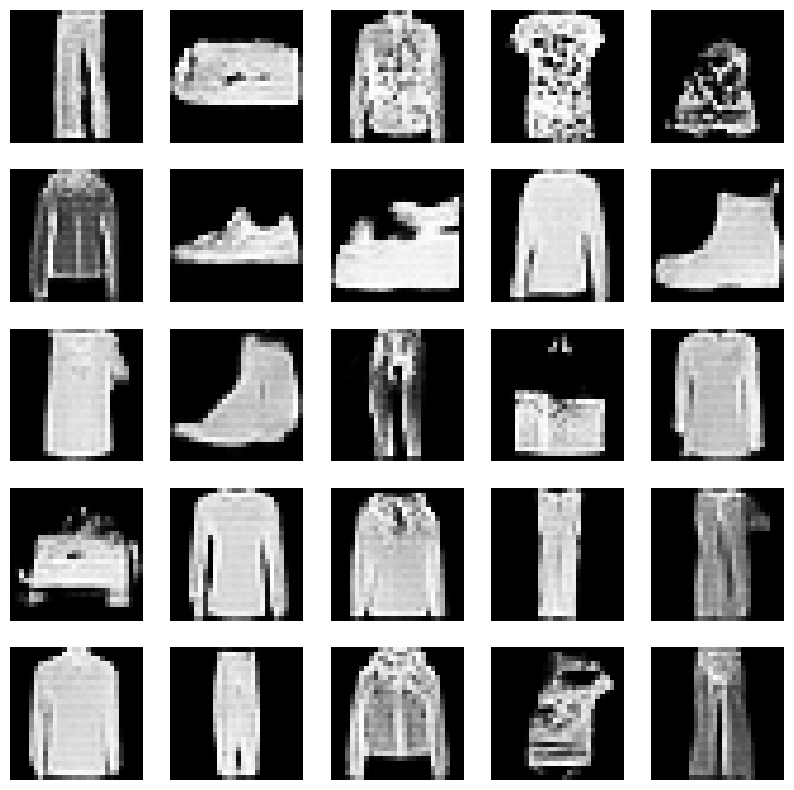

In [30]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
plt

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
generator.save("/content/drive/My Drive/fashion_gan_generator.h5")